In [43]:
!pip install transformers

In [44]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading and preprocessing dataset

In [45]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [46]:
df = df[:2000]
df.head(10)

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
5,campanella gets the tone just right funny in t...,1
6,a fan film that for the uninitiated plays bett...,0
7,"b art and berling are both superb , while hupp...",1
8,"a little less extreme than in the past , with ...",0
9,the film is strictly routine,0


In [47]:
def preprocess(text):
        text = re.sub("^\s+|\n|\r|\s+$", ' ', text)
        return text.strip().lower()

In [48]:
df[0] = df.apply(lambda x: preprocess(x[0]), axis=1)

In [49]:
df.value_counts()

0                                                                                                                                                                                                                                      1
too bad                                                                                                                                                                                                                                0    2
zhuangzhuang creates delicate balance of style , text , and subtext that 's so simple and precise that anything discordant would topple the balance , but against all odds , nothing does                                              1    1
greg kinnear gives a mesmerizing performance as a full fledged sex addict who is in complete denial about his obsessive behavior                                                                                                       1    1
glizty but formulaic and silly cagney 's ` top of the

In [50]:
df

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
1995,too bland and fustily tasteful to be truly pru...,0
1996,it does n't work as either,0
1997,this one aims for the toilet and scores a dire...,0
1998,in the name of an allegedly inspiring and easi...,0


## Loading model

In [51]:
model_name = 'bert-base-uncased'

tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertModel.from_pretrained(model_name)

## Model 1: Preparing the Dataset


In [52]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [53]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [54]:
np.array(padded).shape

(2000, 59)

In [55]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

## Train Model 1

In [56]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [57]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df[1]

## Model 2

In [58]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [59]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
pred = lr_clf.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_clf.score(test_features, test_labels)))

Accuracy of logistic regression classifier on test set: 0.84


In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, pred)
print(confusion_matrix)

[[202  47]
 [ 34 217]]


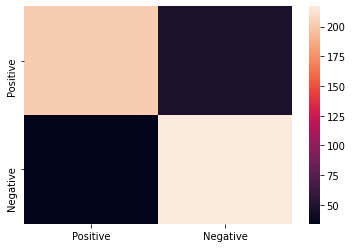

In [62]:
df = pd.DataFrame(confusion_matrix, index = ["Positive", "Negative"], columns = ["Positive", "Negative"])
sns.heatmap(df)